In [54]:
! pip install yfinance
! pip install pandas_datareader

In [55]:
import bs4 as bs
import requests
import yfinance as yf
import datetime
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

In [56]:
tickers=["AIV","AMZN","CL","EW"]

In [57]:
start = datetime.datetime(2012,1,1)
end = datetime.datetime(2020,1,1)
data = yf.download(tickers, start=start, end=end)

[*********************100%***********************]  4 of 4 completed


In [58]:
data.head()

Adj Close                         ...   Volume                  
                  AIV        AMZN         CL  ...     AMZN       CL       EW
Date                                          ...                           
2012-01-03  16.752596  179.029999  35.892979  ...  5110800  6347600  5939400
2012-01-04  16.391708  177.509995  35.703831  ...  4205200  4350200  4015200
2012-01-05  16.680420  177.610001  35.522560  ...  3809100  5232800  4635000
2012-01-06  16.564938  182.610001  35.388565  ...  7008400  3881000  4887600
2012-01-09  16.370054  178.559998  35.380680  ...  5056900  4152400  3301800

[5 rows x 24 columns]

In [59]:
df=pd.DataFrame(data["Adj Close"])
df.head()

,AIV,AMZN,CL,EW
Date,,,,
2012-01-03,16.752596,179.029999,35.892979,12.000000
2012-01-04,16.391708,177.509995,35.703831,11.806666
2012-01-05,16.680420,177.610001,35.522560,11.991667
2012-01-06,16.564938,182.610001,35.388565,12.146667
2012-01-09,16.370054,178.559998,35.380680,12.105000


In [60]:
#compute simple returns
returns = df.pct_change()

# compute standard deviation of returns
return_stdev = returns.std()

#annualize information
annualised_return = round(mean_return * 252, 4)
annualised_stdev = round(return_stdev * np.sqrt(252), 4)

#calculate mean daily return and covariance of daily returns
mean_daily_returns = returns.mean()
#calculate covariance of the returns
cov_matrix = returns.cov()

In [61]:
#set number of runs of random portfolio weights
n = 50000

In [62]:
#set up array to hold results

results = np.zeros(((4+df.shape[1]-1), n))

In [63]:
for i in range(n):
    #select random weights for portfolio holdings
    weights = np.array(np.random.random(df.shape[1]))
    #rebalance weights to sum to 1
    weights /= np.sum(weights)
    #calculate portfolio return and volatility
    portfolio_return = np.sum(mean_daily_returns * weights) * 252
    portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    #store results in results array
    results[0,i] = portfolio_return
    results[1,i] = portfolio_std_dev
    #store Sharpe Ratio (return / volatility) - risk free rate element excluded for simplicity
    results[2,i] = results[0,i] / results[1,i]
    #iterate through the weight vector and add data to results array
    for j in range(len(weights)):
        results[j+3,i] = weights[j]

In [64]:
#convert results array to Pandas DataFrame
column_names=list(['ret','stdev','sharpe']) + list(df.columns)
results_frame = pd.DataFrame(results.T, columns=column_names)

In [65]:
results_frame["sanity_check"]=results_frame.iloc[:,3:].sum(axis=1)
results_frame.head()

,ret,stdev,sharpe,AIV,AMZN,CL,EW,sanity_check
0,0.209110,0.153207,1.364885,0.332684,0.279256,0.240944,0.147115,1.0
1,0.221168,0.161272,1.371392,0.486635,0.268200,0.070818,0.174347,1.0
2,0.241291,0.186255,1.295486,0.081272,0.269311,0.238721,0.410696,1.0
3,0.218143,0.167738,1.300497,0.038646,0.314447,0.401595,0.245312,1.0
4,0.228277,0.170429,1.339429,0.513817,0.375137,0.045251,0.065795,1.0


In [66]:
#locate position of portfolio with highest Sharpe Ratio
max_info_sharpe_port = results_frame.iloc[results_frame['sharpe'].idxmax()]

#locate positon of portfolio with minimum standard deviation
min_vol_port = results_frame.iloc[results_frame['stdev'].idxmin()]

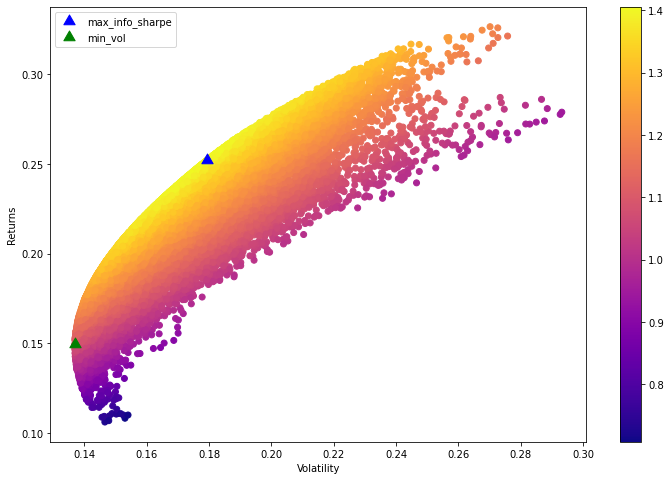

In [67]:
#create scatter plot coloured by Sharpe Ratio
plt.figure(figsize=(12,8))
plt.scatter(results_frame.stdev,results_frame.ret,c=results_frame.sharpe,cmap='plasma')
plt.xlabel('Volatility')
plt.ylabel('Returns')
plt.colorbar()
#plot red star to highlight position of portfolio with highest Sharpe Ratio
plt.scatter(max_info_sharpe_port[1],max_info_sharpe_port[0],marker=(3,1,0),color='b', s=170, label="max_info_sharpe")
#plot green star to highlight position of minimum variance portfolio
plt.scatter(min_vol_port[1],min_vol_port[0],marker=(3,1,0),color='g',s=170, label="min_vol")
plt.legend()

Text(0, 0.5, 'cumulative return')

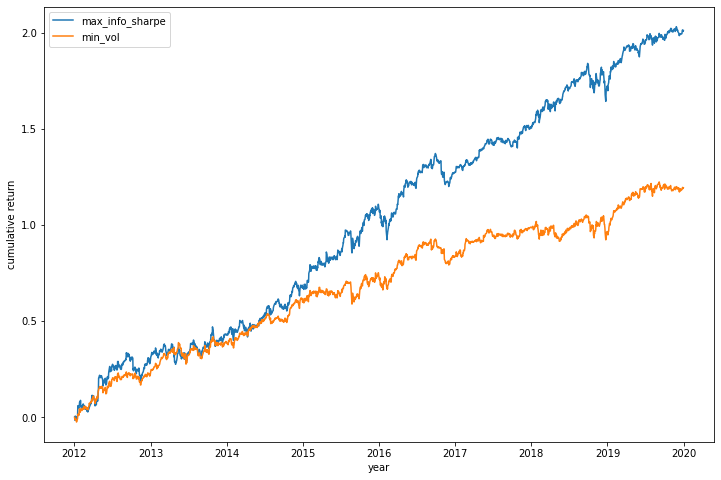

In [68]:
plt.figure(figsize=(12,8))
plt.plot(df.index , np.cumsum((returns*max_info_sharpe_port[df.columns]).sum(axis=1)), label="max_info_sharpe")
plt.plot(df.index , np.cumsum((returns*min_vol_port[df.columns]).sum(axis=1)), label="min_vol")
plt.legend()
plt.xlabel("year")
plt.ylabel("cumulative return")